In [ ]:
%pip install Riskfolio-Lib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import riskfolio as rp
import statsmodels

In [ ]:
data_inicial = 13 #  13 = 01/2005
data_final   = data_inicial + 192 # 12/2020
colunas = 291 #len(comp_indice.columns)
step_port = 1
step_eval = 1

#Composição do índice IBX
comp_indice=pd.read_excel('Dados-Comp-IBRX.xlsx', engine='openpyxl')
comp_indice.set_index(keys = 'Data', inplace = True)

#Preços de fechamento dos ativos
fechamento=pd.read_excel('Dados-Fechamento.xlsx', engine='openpyxl')
fechamento.set_index(keys = 'Data', inplace = True)

#Indices de referência (Ibov, IBX, SELIC...)
referencias=pd.read_excel('Dados-Base.xlsx', engine='openpyxl')
referencias.set_index(keys = 'Data', inplace = True)
#-------------------------------------------

# Fator Qualidade (ROIC das empresas)
fator_ROIC=pd.read_excel('Dados-ROIC-A2.xlsx', engine='openpyxl')
fator_ROIC.set_index(keys = 'Data', inplace = True)
ranked_ROIC=fator_ROIC.rank(axis=1, numeric_only=True, ascending=False, method='first')

# Fator Momentum (Momentum de 12 meses)
fator_Mom=pd.read_excel('Dados-Momentum-12.xlsx', engine='openpyxl')
fator_Mom.set_index(keys = 'Data', inplace = True)
ranked_Mom=fator_Mom.rank(axis=1, numeric_only=True, ascending=False, method='first')

#Fator Tamanho (Valor de mercado das empresas)
fator_Val_Merc=pd.read_excel('Dados-Val-Merc.xlsx', engine='openpyxl')
fator_Val_Merc.set_index(keys = 'Data', inplace = True)
ranked_Val_Merc=fator_Val_Merc.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Valor (Preço / Valor Patrimonial)
fator_PVP=pd.read_excel('Dados-PVP.xlsx', engine='openpyxl')
fator_PVP.set_index(keys = 'Data', inplace = True)
ranked_PVP=fator_PVP.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Volatilidade (Volatilidade em 12 meses)
fator_Vol=pd.read_excel('Dados-Vol-12.xlsx', engine='openpyxl')
fator_Vol.set_index(keys = 'Data', inplace = True)
ranked_Vol=fator_Vol.rank(axis=1, numeric_only=True, ascending=True, method='first')

print("Periodo de avaliacao - de:", comp_indice.index[data_inicial], "(", data_inicial, ")",  "ate:", comp_indice.index[data_final-1], "(", data_final-1, ")")
print("Rebalanceamento a cada", step_eval,"/", step_port, "meses")

Periodo de avaliacao - de: Jan-2005 ( 13 ) ate: Dez-2020 ( 204 )
Rebalanceamento a cada 1 / 1 meses


In [ ]:
#Funções de apoio

#Seleção das ações que compõe um portfólio.
#Parâmetros: (fator, ranking_inicio, ranking_fim)
#Retorno: portfólio
def SelPort1(port_ranked_1, param_1a, param_1b):

    port_ranked_final = port_ranked_1.copy()
    port_ranked_final.loc[:, :] = 0

    for lin in range(data_inicial, data_final, step_port):
        for col in range(0, colunas):
            if ((port_ranked_1.iat[lin-1, col]  >= param_1a) and (port_ranked_1.iat[lin-1, col]  <= param_1b)):
                port_ranked_final.iat[lin-1, col] = 1

    return port_ranked_final
#--------------------------
#Seleção das ações que compõe um portfólio com 2 fatores.
#Parâmetros: (fator1, limite1, fator2, limite2)
#Retorno: portfólio

def SelPort2Par(ranked_1, param_1, ranked_2, param_2):
  port_ranked_final = ranked_1.copy()
  port_ranked_final.loc[:, :] = 0

  for lin in range(data_inicial, data_final, step_port):
    for col in range(0, colunas):
      if ((ranked_1.iat[lin-1, col]  >= 1) and (ranked_1.iat[lin-1, col]  <= param_1) and
          (ranked_2.iat[lin-1, col]  >= 1) and (ranked_2.iat[lin-1, col]  <= param_2)):
        port_ranked_final.iat[lin-1, col] = 1

  return port_ranked_final
#--------------------------
#Seleção das ações que compõe um portfólio com 4 fatores.
#Parâmetros: (fator1, limite1, fator2, limite2, fator3, limite3, fator4, limite4)
#Retorno: portfólio


def SelPort4Par(ranked_1, param_1, ranked_2, param_2, ranked_3, param_3, ranked_4, param_4):
    port_ranked_final = pd.DataFrame(0, index=ranked_1.index, columns=ranked_1.columns)

    # Itera sobre o intervalo de linhas especificado
    for lin in range(data_inicial, data_final, step_port):
        for col in range(0, colunas):
            # Verifica se os rankings para todos os fatores estão dentro dos limites especificados
            if ((ranked_1.iat[lin-1, col] >= 1) and (ranked_1.iat[lin-1, col] <= param_1) and
                (ranked_2.iat[lin-1, col] >= 1) and (ranked_2.iat[lin-1, col] <= param_2) and
                (ranked_3.iat[lin-1, col] >= 1) and (ranked_3.iat[lin-1, col] <= param_3) and
                (ranked_4.iat[lin-1, col] >= 1) and (ranked_4.iat[lin-1, col] <= param_4)):
                port_ranked_final.iat[lin-1, col] = 1

    return port_ranked_final


#--------------------------

#Avaliação de um portfólio.
#Parâmetros: (portfólio, histórico de preços dos ativos)
#Retorno: vetor com retorno acumulado, vetor com retornos periódicos, vetor com drawdown, retorno anualizado, volatilidade anualizada
def EvalPort(port, fechamento):
    port_acc_vet = []
    port_chg_vet = []
    port_ddown_vet = []

    port_acc = 1.0
    port_acc_vet.append(1.0)
    cost_trans = 0.0006
    #cost_trans = 0.0005 + (0.004*step_eval/12)

    for lin in range(data_inicial, data_final, step_eval):
        cont = 0.0
        rent = 0.0
        for col in range(0, colunas):
            if (port.iat[lin-1, col] > 0 and fechamento.iat[lin-1, col]>0 and fechamento.iat[lin-1+step_eval, col]>0):
                rent = rent + (fechamento.iat[lin-1+step_eval,col]/fechamento.iat[lin-1,col]-1)*(port.iat[lin-1, col])
                cont = cont + port.iat[lin-1, col]
        if (cont == 0):
          return [1,1], [1,1], [0,0], 0, 0.000001
        port_acc = port_acc * (1.0 + rent/cont - cost_trans)
        port_chg_vet.append(rent/cont - cost_trans)
        port_acc_vet.append(port_acc)
        port_ddown_vet.append(port_acc/(np.max(port_acc_vet))-1)

    ret_aa = pow(port_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(port_chg_vet)*((12/step_eval)**(1/2))
    return port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa
#--------------------------

#Avaliação de um índice de referência.
#Parâmetros: (dataframe de referências, indice da referência desejada [0 - Ibovespa, 1 - IBX])
##Retorno: vetor com retorno acumulado, vetor com retornos periódicos, vetor com drawdown, retorno anualizado, volatilidade anualizada
def EvalRef(ref, ind):
    ref_acc_vet = []
    ref_chg_vet = []
    ref_ddown_vet = []

    ref_acc = 1.0
    ref_acc_vet.append(1.0)

    for lin in range(data_inicial, data_final, step_eval):
        rent = ref.iat[lin-1+step_eval,ind]/ref.iat[lin-1,ind]
        ref_acc = ref_acc * rent
        ref_chg_vet.append(rent-1)
        ref_acc_vet.append(ref_acc)
        ref_ddown_vet.append(ref_acc/(np.max(ref_acc_vet))-1)

    ret_aa = pow(ref_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(ref_chg_vet)*((12/step_eval)**(1/2))
    return ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa, vol_aa


In [ ]:
#-------------------------- Riskfolio ----------

def calc_riskfolio_opt (ranked, otim_opt):
  hist_size = 24
  port = ranked.copy()
  #rm = rm_par

  if (otim_opt == 'RP'):
    print("\nCalc. Risk Parity Portfolio")
  elif (otim_opt == 'GMV'):
    print("\nCalc. Global Minimun Variance Portfolio")
  elif (otim_opt == 'MDP'):
    print("\nCalc. Maximun Decorrelation Portfolio")
  else:
    print("\nOpcao Invalida.")

#  print("\nCalc HRP")

  for lin in range(data_inicial+hist_size, data_final, 1):
    print("\r",lin, "/", data_final-1, end=' ')
    port_comp = pd.DataFrame()
    for col in range(0, colunas):
      if (port.iat[lin-1, col] > 0):
        port_comp[port.columns[col]]=fechamento[port.columns[col]].iloc[lin-1-hist_size:lin-1]

    port_comp.fillna(method='backfill', axis=0, inplace=True)

    port_comp_chg = port_comp.pct_change().dropna()


#---------
    # Hierarchical Risk Parity
    #hrp_port = rp.HCPortfolio(returns=port_comp_chg)
    #w = hrp_port.optimization(model=model, codependence=codependence, rm='MV', rf=0, linkage='average', max_k=10, leaf_order=True)

    # Standard Risk Parity
    if (otim_opt == 'RP'):
      rp_port = rp.Portfolio(returns=port_comp_chg)
      rp_port.assets_stats(d=0.94, method_cov='hist')
      w = rp_port.rp_optimization(rm='MV', b = None)

    # Minimun Variance
    elif (otim_opt == 'GMV'):
      gmv_port = rp.Portfolio(returns=port_comp_chg)
      gmv_port.assets_stats(d=0.94)
      w = gmv_port.optimization(model='Classic', rm='MV', obj='MinRisk')

    # Maximun Decorrelation
    elif (otim_opt == 'MDP'):
      mdp_port = rp.Portfolio(returns=port_comp_chg)
      mdp_port.assets_stats(d=0.94)
      mdp_port.cov = port_comp_chg.corr()
      w = mdp_port.optimization(model='Classic', rm='MV', obj='MinRisk')


#-----------

    port_len = len(port_comp_chg.columns)
    for at in range(port_len):
      port.at[port.index[lin-1], port_comp.columns[at]] = w['weights'].iat[at]
      #if ((lin-1)==40):
      #  print(port_comp.columns[at], w['weights'].iat[at])

    #if ((lin-1)==40):
    #  display(w)

  port_final = port.copy()
  return port_final

In [ ]:
# Cálculo de rentabilidade / volatilidade / drawdown da SELIC
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 2)
print("Ref SELIC:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do IBX
#ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 1)
#print("Ref IBX:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do Ibovespa
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 0)
print("Ref Ibov:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")



Ref SELIC:
Ret. Acc.: 397.54 % Ret. Anual.: 10.55 % Vol.: 1.05 % Ret/Vol: 10.04 DDown: 0.0 %
Ref Ibov:
Ret. Acc.: 354.33 % Ret. Anual.: 9.92 % Vol.: 23.45 % Ret/Vol: 0.42 DDown: -49.59 %


In [ ]:
#encontrando maior retorno / volatilidade

import itertools

# Valores de ranking fixo
rankings_fixos = [30, 40, 50]

# Inicializando a maior razão retorno/volatilidade como um valor muito pequeno
melhor_sharpe = -np.inf
melhor_comb = None
melhor_ranking = None

fatores = {
    "ROIC": ranked_ROIC,
    "VOL": ranked_Vol,
    "Val_Merc": ranked_Val_Merc,
    "PVP": ranked_PVP,
    "Mom": ranked_Mom
}

# Iterando sobre todos os valores de ranking fixo e todas as combinações de fatores para dois fatores
for ranking_fixo in rankings_fixos:
    for comb in itertools.combinations(fatores.keys(), 2):
        ranked_portfolio = SelPort2Par(fatores[comb[0]], ranking_fixo, fatores[comb[1]], ranking_fixo)
        port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa = EvalPort(ranked_portfolio, fechamento)

        # Calcular a razão retorno/volatilidade
        if vol_aa != 0:
            sharpe_ratio = ret_aa / vol_aa
            if sharpe_ratio > melhor_sharpe:
                melhor_sharpe = sharpe_ratio
                melhor_comb = comb
                melhor_ranking = ranking_fixo

if melhor_comb is not None:
    print("Melhor combinação de fatores com ranking fixo de {} (maior razão retorno/volatilidade):".format(melhor_ranking))
    print("Fatores:", melhor_comb)
    print("Ranking:", melhor_ranking)
    print("Retorno Anualizado:", round(ret_aa * 100, 2), "%")
    print("Volatilidade Anualizada:", round(vol_aa * 100, 2), "%")
    print("Retorno/Volatilidade (Sharpe Ratio):", round(melhor_sharpe, 2))
else:
    print("Nenhuma combinação resultou em volatilidade diferente de 0.")



Melhor combinação de fatores com ranking fixo de 30 (maior razão retorno/volatilidade):
Fatores: ('VOL', 'Mom')
Ranking: 30
Retorno Anualizado: 17.82 %
Volatilidade Anualizada: 23.13 %
Retorno/Volatilidade (Sharpe Ratio): 1.18


In [ ]:
# Valores de ranking fixo
rankings_fixos = [30, 40, 50]

# Inicializando o maior retorno anualizado como menos infinito
maior_ret = -np.inf
melhor_comb = None
melhor_ranking = None

# Iterando sobre todos os valores de ranking fixo e todas as combinações de fatores para dois fatores
for ranking_fixo in rankings_fixos:
    for comb in itertools.combinations(fatores.keys(), 2):
        ranked_portfolio = SelPort2Par(fatores[comb[0]], ranking_fixo, fatores[comb[1]], ranking_fixo)
        port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa = EvalPort(ranked_portfolio, fechamento)

        if ret_aa > maior_ret:
            maior_ret = ret_aa
            melhor_comb = comb
            melhor_ranking = ranking_fixo

if melhor_comb is not None:
    print("Melhor combinação de fatores com ranking fixo de {} (maior retorno anualizado):".format(melhor_ranking))
    print("Fatores:", melhor_comb)
    print("Ranking:", melhor_ranking)
    print("Retorno Anualizado:", round(maior_ret * 100, 2), "%")
else:
    print("Nenhuma combinação resultou em retorno anualizado diferente de 0.")


Melhor combinação de fatores com ranking fixo de 40 (maior retorno anualizado):
Fatores: ('ROIC', 'PVP')
Ranking: 40
Retorno Anualizado: 23.32 %


In [ ]:
# maior retorno / volatilidade
ranked1 = SelPort2Par(ranked_Mom, 30, ranked_Vol, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("\nPort 1:\nRet. Acc.:", round(port_acc_vet1[-1]*100-100, 2), "% Ret. Anual.:", round(ret_aa1*100, 2), "% Vol.:", round(vol_aa1*100, 2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100, 2), "%")

# maior retorno anual
ranked2 = SelPort2Par(ranked_ROIC, 40, ranked_PVP, 40)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("\nPort 2:\nRet. Acc.:", round(port_acc_vet2[-1]*100-100, 2), "% Ret. Anual.:", round(ret_aa2*100, 2), "% Vol.:", round(vol_aa2*100, 2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100, 2), "%")



Port 1:
Ret. Acc.: 2422.46 % Ret. Anual.: 22.35 % Vol.: 19.0 % Ret/Vol: 1.18 DDown: -30.97 %

Port 2:
Ret. Acc.: 2762.97 % Ret. Anual.: 23.32 % Vol.: 26.27 % Ret/Vol: 0.89 DDown: -60.37 %


In [ ]:
#Tentei aplicar o problema com rank nao definido com mais de dois fatores, entretanto excedeu tempo de execução.

import itertools

# Definindo os parâmetros
data_inicial = 13  # 13 = 01/2005
data_final = data_inicial + 192  # 12/2020
colunas = 291  # len(comp_indice.columns)
step_port = 1
step_eval = 1

fatores = {
    "ROIC": ranked_ROIC,
    "VOL": ranked_Vol,
    "Val_Merc": ranked_Val_Merc,
    "PVP": ranked_PVP,
    "Mom": ranked_Mom
}

# Intervalo de ranking
ranking_range = range(20, 50)

melhor_ret = -np.inf
melhor_comb = None

# Iterando sobre todas as combinações de fatores e tamanhos de ranking para dois fatores
for comb in itertools.combinations(fatores.keys(), 2):
    for rank in itertools.product(ranking_range, repeat=2):
        ranked_portfolio = SelPort2Par(fatores[comb[0]], rank[0], fatores[comb[1]], rank[1])
        port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa = EvalPort(ranked_portfolio, fechamento)

        if ret_aa > melhor_ret:
            melhor_ret = ret_aa
            melhor_comb = (comb, rank)

print("Melhor combinação de fatores e rankings:")
print("Fatores:", melhor_comb[0])
print("Rankings:", melhor_comb[1])
print("Retorno Anualizado:", round(melhor_ret * 100, 2), "%")



In [ ]:
#Otimizando os portfolios

port_riskfolio = calc_riskfolio_opt(ranked1, 'RP')
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet4, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked1, 'GMV')
port_acc_vet5, port_chg_vet5, port_ddown_vet5, ret_aa5, vol_aa5 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRet. Acc.:",round(port_acc_vet5[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa5*100,2), "% Vol.:", round(vol_aa5*100,2), "% Ret/Vol:", round(ret_aa5/vol_aa5, 2), "DDown:", round(np.min(port_ddown_vet5)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet5, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked1, 'MDP')
port_acc_vet6, port_chg_vet6, port_ddown_vet6, ret_aa6, vol_aa6 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRet. Acc.:",round(port_acc_vet6[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa6*100,2), "% Vol.:", round(vol_aa6*100,2), "% Ret/Vol:", round(ret_aa6/vol_aa6, 2), "DDown:", round(np.min(port_ddown_vet6)*100,2), "%")
#enc = calc_ENC(port_riskfolio)
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet6, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Calc. Risk Parity Portfolio
 204 / 204 
Port RP:
Ret. Acc.: 1995.32 % Ret. Anual.: 20.94 % Vol.: 18.66 % Ret/Vol: 1.12 DDown: -33.4 %
Port Alpha: 14.18 %, Beta: 0.55

Calc. Global Minimun Variance Portfolio
 204 / 204 
Port GMV:
Ret. Acc.: 1201.98 % Ret. Anual.: 17.4 % Vol.: 19.1 % Ret/Vol: 0.91 DDown: -33.47 %
Port Alpha: 11.83 %, Beta: 0.5

Calc. Maximun Decorrelation Portfolio
 204 / 204 
Port MDP:
Ret. Acc.: 1367.04 % Ret. Anual.: 18.28 % Vol.: 19.05 % Ret/Vol: 0.96 DDown: -33.16 %
Port Alpha: 12.31 %, Beta: 0.52


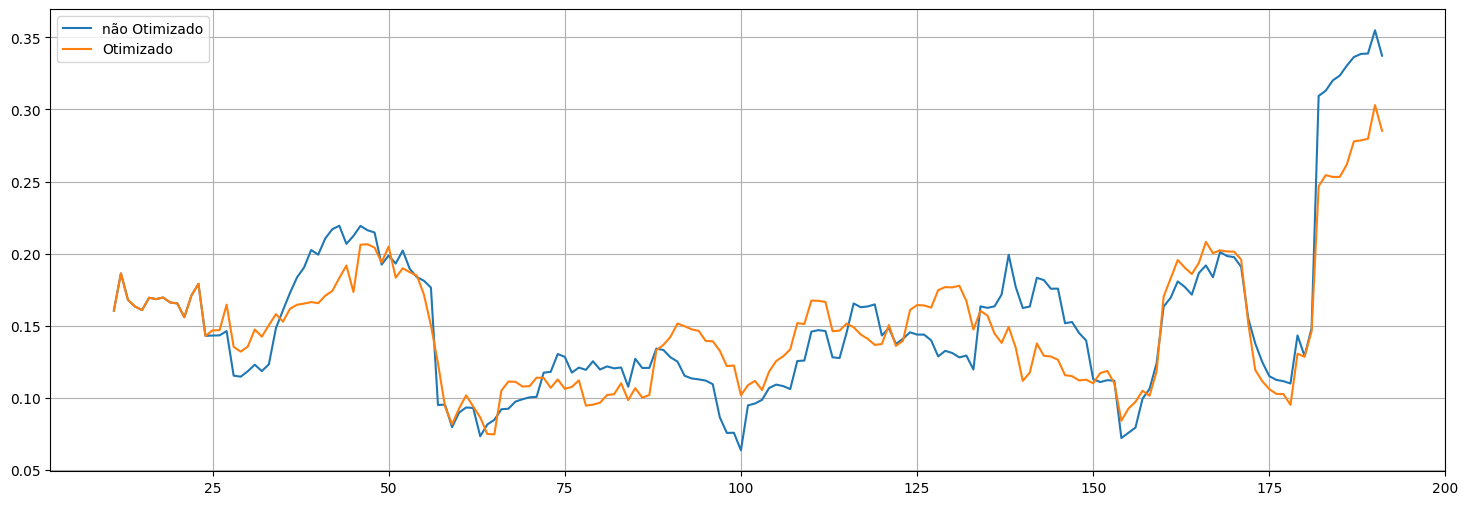

In [ ]:
final_vol_df = pd.DataFrame()
final_vol_df['não Otimizado'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Otimizado'] = pd.Series(port_chg_vet5).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);